In [2]:
import pandas as pd
import scipy as sp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split,StratifiedShuffleSplit,StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import json as js
import pickle as pkl
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from scipy  import stats
from sklearn import preprocessing
from sklearn.decomposition import PCA
import re
import os
from sklearn.externals.six import StringIO
import matplotlib.pyplot as plt
import pydot

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
def reFind(str, x, na):
    ar = re.compile(str).findall(x)
    if len(ar) ==0:
        return na
    else:
        return ar[0]

In [4]:
def prepareData(df, seed):
    
    print('cleaning features...')
    scaler = preprocessing.StandardScaler()

    ##-- Cabin --
    df['CabinNA'] = df.Cabin.isnull()
    df.Cabin = df.Cabin.fillna('U0')

    df['CabinFactor'] = pd.factorize(df.Cabin)[0]

    df['CabinLetter'] = df.Cabin.map(lambda x: reFind("([a-zA-z]+)", x, ''))
    dum = pd.get_dummies(df.CabinLetter,prefix='CabinLetter')
    df = pd.concat([df, dum], 1)
    df['CabinLetterFactor'] = df.CabinLetter.map({'A':0,
                                                  'B':1,
                                                  'C':2,
                                                  'D':3,
                                                  'E':4,
                                                  'F':5,
                                                  'G':6,
                                                  'T':7,
                                                  'U':8})
    df['CabinLetterBin'] = df.CabinLetter.map({'A':0,
                                                  'B':0,
                                                  'C':0,
                                                  'D':1,
                                                  'E':1,
                                                  'F':1,
                                                  'G':2,
                                                  'T':2,
                                                  'U':2})
    

    df['CabinNumber'] = df.Cabin.map(lambda x: reFind("([0-9]+)", x, '0')).astype(int)
    ##df['CabinNumberBin'] = df.CabinNumber.map(lambda x: )
    ##df['CabinNumberBin'] = pd.qcut(df.CabinNumber,3)
    ##df.CabinNumberBin = pd.factorize(df.CabinNumberBin)[0]
    
    ##-- Embarked --
    df.Embarked = df.Embarked.fillna(df.Embarked.mode()[0])

    df['EmbarkedFactor'] = pd.factorize(df.Embarked)[0]

    dum = pd.get_dummies(df.Embarked,prefix='Embarked')
    df = pd.concat([df, dum], 1)
    
    ##-- Fare --
    fare_med = pd.pivot_table(df,values='Fare', index='Pclass', aggfunc='median')
    
    df.Fare = df[['Fare','Pclass']].apply(lambda x: fare_med[int(x.Pclass)] if pd.isnull(x.Fare) else x.Fare, 1)

##    df['FareScaled'] = scaler.fit_transform(df.Fare)
    
    df['FareBin'] = pd.qcut(df.Fare,5)
    df.FareBin = pd.factorize(df.FareBin)[0]
    
    ##-- Age --
    df['AgeNA'] = df.Age.isnull()
    
    knownAge = df.loc[df.Age.notnull(),:]
    unknownAge = df.loc[df.Age.isnull(),:]
    dropCol = ['Age','Survived','Cabin','Embarked','Name','Sex','Ticket','CabinLetter','CabinNumber']
    x_train = knownAge.drop(dropCol,1)
    y_train = knownAge.Age
    x_test = unknownAge.drop(dropCol,1)
    rfr = RandomForestRegressor(n_estimators=2000, n_jobs=-1, random_state = seed)
    rfr.fit(x_train,y_train)
    df.loc[unknownAge.index,'Age'] = rfr.predict(x_test)

    
##    df['AgeScaled'] = scaler.fit_transform(df.Age)

    df['AgeBin'] = pd.qcut(df.Age,5)
    df.AgeBin = pd.factorize(df.AgeBin)[0]

    ##-- Parch --
    ##df['ParchBin']=pd.qcut(df.Parch, 3)
    ##df.ParchBin = pd.factorize(df.ParchBin)[0]

    ##-- Sex --
    df.Sex = pd.factorize(df.Sex)[0]

    ##-- SibSp --
    ##df['SibSpBin']=pd.qcut(df.SibSp, 2)
    ##df.SibSpBin = pd.factorize(df.SibSpBin)[0]
    

    ##-- Name --
    df['NameLen'] = df.Name.map(lambda x: len(re.split(' ',x)))

    df['Title'] = df.Name.map(lambda x: re.compile(", (.*?)\.").findall(x)[0])
    titles={'Master': ['Jonkheer'],
            'Miss': ['Ms', 'Mlle'],
            'Mrs': ['Mme'],
            'Sir': ['Capt','Don','Major','Col'],
            'Lady': ['Dona', 'the Countess']}
    df['TitleBin']=df.Title
    for i in titles:
        df.loc[df.Title.isin(titles[i]),'TitleBin'] = i
    dum = pd.get_dummies(df.TitleBin, prefix='Title')
    df = pd.concat([df,dum],1)
    df.TitleBin = pd.factorize(df.TitleBin)[0]

    df['Surname'] = df.Name.map(lambda x: re.split(' ',x)[0])
    

    ##-- Ticket --
    df['TicketPrefix'] = df.Ticket.map(lambda x: reFind("([a-zA-z\.\/]+)", x, ''))
    df['TicketPrefix'] = df.TicketPrefix.map(lambda x: re.sub("[\.\/]",'',x))
    dum = pd.get_dummies(df.TicketPrefix, prefix='TicketPrefix')
    df = pd.concat([df,dum],1)
    df.TicketPrefix = pd.factorize(df.TicketPrefix)[0]

    df['TicketNumber'] = df.Ticket.map(lambda x: reFind("([\d]+$)", x, '0')).astype(int)
    df['TicketNumberLen'] = df.TicketNumber.map(lambda x: len(str(x))).astype(int)
    df['TicketNumberFD'] = df.TicketNumber.map(lambda x: str(x)[0]).astype(int)

    df['TicketNumberBin'] = pd.qcut(df.TicketNumber, 10)
    df.TicketNumberBin = pd.factorize(df.TicketNumberBin)[0]


    ##-- new features --
    print('making new features...')
    df['FamilySize'] = df.Parch+df.SibSp
    
    df['FamilyId'] = df[['FamilySize','Surname']].apply(lambda x: x.Surname+str(x.FamilySize),1)
    df.FamilyId = pd.factorize(df.FamilyId)[0]

##    columns = ['Pclass','Sex','SibSp','Parch','CabinFactor', 'CabinLetterFactor','CabinNumber','EmbarkedFactor','Fare','Age','NameLen','TitleBin','TicketPrefix','TicketNumber','TicketNumberLen','FamilySize','FamilyId']
##    for i,iel in enumerate(columns):
##        for j,jel in enumerate(columns):
##            if i < j:
##                df[iel+"+"+jel] = df[iel]+df[jel]
##            if i <= j:
##                df[iel+"*"+jel] = df[iel]*df[jel]
##            if i != j:
##                df[iel+"/"+jel] = df[iel]/df[jel].astype(float)
##                df[iel+"-"+jel] = df[iel]-df[jel]
##
    ##y = df.Survived
##
    df = df.drop(['Cabin', 'Embarked', 'Name', 'Ticket', 'CabinLetter', 'Title', 'Surname','PassengerId'],1)
##    
##    have_null = sp.sum(pd.isnull(df))
##    df = df.drop(have_null[have_null>0].index.tolist(),1)
##
##    have_inf = [k for k in df.columns if sp.sum(sp.isinf(df[k]))>0]
##    df = df.drop(have_inf,1)
        
    ##-- check correlated features --
    ##print('deleting correlated features...')
##    df_corr = df.corr(method = 'spearman')
##    mask = sp.ones(df_corr.columns.size) - sp.eye(df_corr.columns.size)
##    df_corr = df_corr*mask
##    dels=[]
##    for i in df_corr.columns:
##        if i in dels:
##            continue
##        inds = df_corr.loc[abs(df_corr[i])>=0.98,i].index.tolist()
##        for ind in inds:
##            if ind not in dels:
##                dels.append(ind)
##    df = df.drop(dels,1)

    
    ##-- PCA --
##    print('making pca...')
##    pca=PCA(0.9999999999)
##    Xtrans = pca.fit_transform(df)
    ##df = pd.concat([df, y],1)
    return df

###Reading settings

In [5]:
config = js.loads(open('../SETTINGS.json').read())
train_path = "../"+config["TRAIN_DATA_PATH"]
test_path = "../"+config["TEST_DATA_PATH"]
model_path = "../"+config["MODEL_PATH"]
seeed = int(config["SEED"])

###Getting data

In [6]:
df_train = pd.read_csv(train_path+"/train.csv")
df_test = pd.read_csv(test_path+"/test.csv")

df_full = pd.concat([df_train,df_test])
df_full = df_full.reset_index()
df_full = df_full.drop('index',1)


df_full = prepareData(df_full, seeed)
d_train = df_full.loc[df_full.Survived.notnull(),:]

x_train = d_train.drop('Survived',1)
y_train = d_train.Survived

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=seeed)

cleaning features...
making new features...


###Simple decision tree

In [7]:
dt_cls = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=5, min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, max_features=None, random_state=seeed, max_leaf_nodes=None, 
                                class_weight=None)
dt_cls.fit(x_train, y_train)
print(dt_cls.score(x_test,y_test))



0.77094972067


In [9]:
params={
    "max_depth": sp.arange(1,11),
    "min_samples_split": sp.arange(1,21),
    "min_samples_leaf": sp.arange(1,41)
}
gs = GridSearchCV(dt_cls, params, scoring=None, loss_func=None, score_func=None, 
                  fit_params=None, n_jobs=4, iid=True, refit=True, cv=5, verbose=1, 
                  pre_dispatch='2*n_jobs', error_score='raise')
gs.fit(x_train, y_train)

[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 200 jobs       | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 450 jobs       | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 800 jobs       | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 1250 jobs       | elapsed:   16.5s
[Parallel(n_jobs=4)]: Done 1800 jobs       | elapsed:   21.8s
[Parallel(n_jobs=4)]: Done 2450 jobs       | elapsed:   28.0s
[Parallel(n_jobs=4)]: Done 3200 jobs       | elapsed:   35.3s
[Parallel(n_jobs=4)]: Done 4050 jobs       | elapsed:   43.5s
[Parallel(n_jobs=4)]: Done 5000 jobs       | elapsed:   53.7s
[Parallel(n_jobs=4)]: Done 6050 jobs       | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 7200 jobs       | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 8450 jobs       | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 9800 jobs       | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 11250 jobs       | elapsed:  2.2min
[Parallel(n_

Fitting 5 folds for each of 8000 candidates, totalling 40000 fits


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            random_state=1, splitter='best'),
       fit_params={}, iid=True, loss_func=None, n_jobs=4,
       param_grid={'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40]), 'min_samples_split': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]), 'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=1)

In [10]:
print(gs.best_params_)
print(gs.best_score_)

{'min_samples_leaf': 32, 'min_samples_split': 1, 'max_depth': 3}
0.823033707865


- best-params: {'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 1}
- best-score: 0.8230337078651685

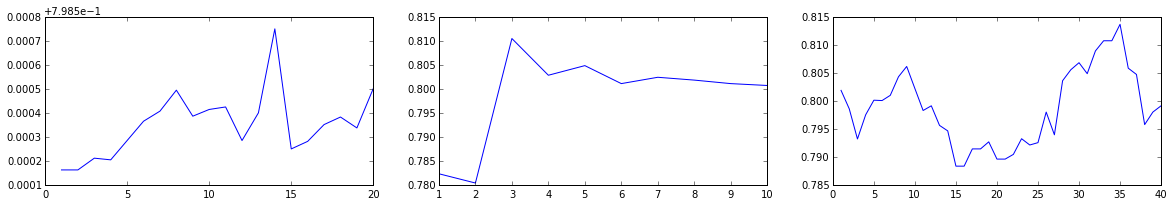

In [30]:
min_splits=[]
max_depths=[]
min_leafs=[]
errors = []
stds=[]
for el in gs.grid_scores_:
    min_splits.append(el.parameters['min_samples_split'])
    max_depths.append(el.parameters['max_depth'])
    min_leafs.append(el.parameters['min_samples_leaf'])
    errors.append(el.mean_validation_score)
    stds.append(std(el.cv_validation_scores))
errdf = pd.DataFrame({"min_splits":min_splits, "max_depths": max_depths, "min_leafs": min_leafs, "error": errors, "std": stds})
errdf.to_csv("dt_cls_err.csv")

figure(figsize=(20, 3), dpi=80)
subplot(1,3,1)
ms = pd.pivot_table(data=errdf, values=["error","std"], index="min_splits", aggfunc="mean")
plot(ms.index, ms.error)
subplot(1,3,2)
ms = pd.pivot_table(data=errdf, values=["error","std"], index="max_depths", aggfunc="mean")
plot(ms.index, ms.error)
subplot(1,3,3)
ms = pd.pivot_table(data=errdf, values=["error","std"], index="min_leafs", aggfunc="mean")
plot(ms.index, ms.error)

In [31]:
gs.score(x_test,y_test)

0.7988826815642458